# Remove and restore a coseismic model in _isce_

Gareth Funning, University of California, Riverside

Can we make a synthetic earthquake image and remove it from the data before unwrapping?

In [1]:
# First some dependencies. Hopefully you have them all!
# (you may need to run this before you run jupyter...
#  export PYTHONPATH=$PYTHONPATH:/home/gareth/pkgs/okapy )
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, tan, radians
from osgeo import osr, gdal
from okada_wrapper import dc3dwrapper
import utm
# new depedencies ise image
import isce
import isceobj
from stdproc.model.enu2los.ENU2LOS import ENU2LOS
import os

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce


In [16]:
# input files
ifgpath="/scratch/alor_2015_dsc_III/"                     # directory with your interferogram
ifgname="/home/karlee/earthquakes/alor_2015_JupNot/dsc_half_fringe_digitized/prepareInSARdata/filt_topophase_snapu.unw"                                      # interferogram file
corname="interferogram/topophase.cor.geo"                                           # correlation file
lospath=ifgpath                                                       # can specify different path for los information
losname="geometry/los.rdr.geo"                                                 # line-of-sight file
latname='geometry/lat.rdr'
lonname='geometry/lon.rdr'
losrdrname='geometry/los.rdr'
mskname="crop.wbd"
pickle='PICKLE'
interphs='interferogram/phase.flat'


# water mask file (optional)
# imported this water mask from the make water mask
#use_water_mask=True

# a file or two to write out
out_tif_utm='model_3components_utm.tif'
out_tif_ll='model_3components_ll.tif'
out_isce_ll='model.enu'
out_isce = 'model.geo'
out_isce_residual = 'residual.geo'


# get the present working directory so that can come back here!
pwd=os.getcwd()

wavel = 0.2362     # radar wavelength in m
pix_size = 30      # scale to geocoding DEM (e.g. 30 m for SRTM1)

sig_con = 1         # insar sign convention (1 = range change, -1 = ground displacement)


# add your coseismic model details here
ske = 117      # strike
dip = 61    # dip
rke = -154    # rake
slp = 1.89      # slip

sx = 717722     # coordinates of center of fault plane
sy = 9090537    # projected updip to the surface

lgh = 12191    # fault length
top = 1497     # top depth of fault
bot = 7616     # bottom depth of fault

# a vector of elastic parameters
eparams = (30e9, 30e9)  # 1st and 2nd Lame elastic parameters; try 30 GPa for both

# calculate some derived parameters

# various 'sizes'
wdh = (bot-top)/sin(radians(dip)) # down-dip width
cdh = (top+bot)/2                 # centroid depth
mom = lgh*wdh*slp*eparams[1]      # seismic moment

# the centroid coordinates
rc=cdh/tan(radians(dip))  # radial surface distance from (xs,ys) to centroid
rcx=rc*sin(radians(ske+90)) # coordinate shift in x from sx to centroid 
rcy=rc*cos(radians(ske+90)) # coordinate shift in y from sy to centroid
xc=sx+rcx  # x coordinate of centroid
yc=sy+rcy  # y coordinate of centroid

# strike-slip and dip-slip
ss=slp*cos(radians(rke))
ds=slp*sin(radians(rke))

# elastic constant used by Okada
alpha = (eparams[0]+eparams[1])/(eparams[0]+2*eparams[1]) 

# make a rotation matrix to account for strike
R=np.array([[cos(radians(ske-90)), -sin(radians(ske-90))], 
            [sin(radians(ske-90)), cos(radians(ske-90))]])

print('strike {0:f}, dip {1:f}, rake {2:f}, slip {3:f}'.format(ske,dip,rke,slp))
print(' x {0:f}, y {1:f}, length {2:f}, top {3:f}, bottom {4:f}'.format(sx,sy,lgh,top,bot))
#print('USGS centroid lon {0:f}, lat {1:f}, depth {2:f}'.format(clon,clat,cdep))


strike 117.000000, dip 61.000000, rake -154.000000, slip 1.890000
 x 717722.000000, y 9090537.000000, length 12191.000000, top 1497.000000, bottom 7616.000000


In [17]:
# load in your data manually!
ifgfile=gdal.Open(ifgname,gdal.GA_ReadOnly)   # open with gdal
# i changed this to 1 --> it was 2
rb = ifgfile.GetRasterBand(1)                         # phase info is in band 2
phs = rb.ReadAsArray()                                # read it in as a number array

# line-of-sight information
losfile=gdal.Open(lospath+losname,gdal.GA_ReadOnly)   # open with gdal
rb = losfile.GetRasterBand(1)                         # incidence info is in band 1
inc = rb.ReadAsArray()                                # read it in as a number array
rb = losfile.GetRasterBand(2)                         # pointing azimuth info is in band 2
pnt = rb.ReadAsArray()                                # read it in as a number array


# get metadata for the image: frame size, pixel size and reference point
gt = losfile.GetGeoTransform()    # geotransform information
nN = losfile.RasterYSize
nE = losfile.RasterXSize
dN = gt[5]
dE = gt[1]
refLat = gt[3]
refLon = gt[0]

maxLon = refLon+(nE)*dE
minLat = refLat+(nN)*dN

print('longitude bounds: {0:f} to {1:f}, {2:d} columns, pixel size: {3:f}'.format(refLon,maxLon,nE,dE))
print('latitude bounds: {0:f} to {1:f}, {2:d} rows, pixel size: {3:f}'.format(minLat,refLat,nN,dN))

longitude bounds: 124.489444 to 125.260000, 2774 columns, pixel size: 0.000278
latitude bounds: -8.749167 to -7.998056, 2704 rows, pixel size: -0.000278


In [36]:
nE

2774

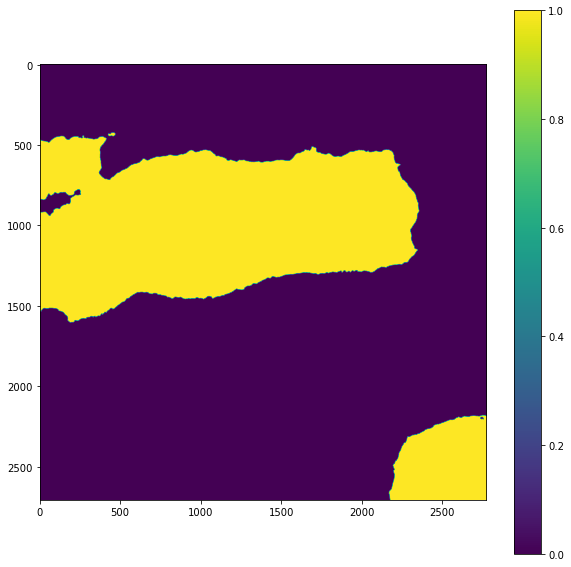

In [18]:
# load in the watermask
ifgfile=gdal.Open(ifgpath+mskname,gdal.GA_ReadOnly)
rb = ifgfile.GetRasterBand(1)                         # phase info is in band 2
wmsk = rb.ReadAsArray()                                # read it in as a number array
# optionally plot your inputs

wmask=np.zeros_like(wmsk)  # zero array same size as wbd mask
wmask[wmsk==0]=1

fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(wmask,origin='upper')             # plot incidence with origin at upper left (isce default)
fig.colorbar(im)                               # plot a color bar!
plt.show()

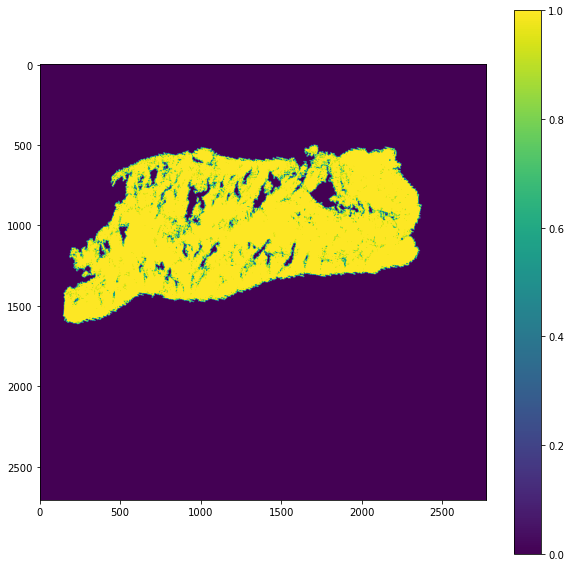

In [19]:
# load in the connecting component parts to mask if wanted 
ifgfile=gdal.Open('/scratch/save_org_filt/filt_topophase.unw.conncomp.geo',gdal.GA_ReadOnly)
rb = ifgfile.GetRasterBand(1)                         # phase info is in band 2
cwmsk = rb.ReadAsArray()                                # read it in as a number array

# fix the connecting components to be a water mask
ccmask = (cwmsk==4)

fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(ccmask,origin='upper')             # plot the masked interferogram file
fig.colorbar(im)                               # plot a color bar!
plt.show()

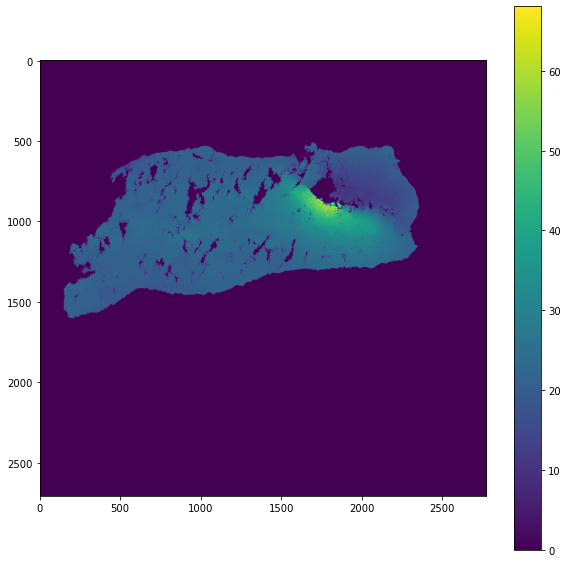

In [20]:
# optionally plot your inputs
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(phs,origin='upper')             # plot incidence with origin at upper left (isce default)
fig.colorbar(im)                               # plot a color bar!
plt.show()

In [21]:
# convert the epicenter coordinates to UTM
X, Y, utmz, utml = utm.from_latlon(np.array([refLat, minLat]),np.array([refLon, maxLon]))

# round these coordinates up and down to the nearest 30 m

minX = np.floor(X[0]/pix_size)*pix_size
maxX = np.ceil(X[1]/30)*pix_size
minY = np.floor(Y[1]/pix_size)*pix_size
maxY = np.ceil(Y[0]/pix_size)*pix_size

nx = int((maxX-minX)/pix_size)+1
ny = int((maxY-minY)/pix_size)+1

print('X bounds: {0:f} to {1:f}'.format(minX, maxX))
print('Y bounds: {0:f} to {1:f}'.format(minY, maxY))

# make some utm coordinates
x = np.linspace(minX, maxX, nx)  # these are the plot bounds
y = np.linspace(minY, maxY, ny)

XX, YY = np.meshgrid(x,y)

X bounds: 664140.000000 to 748650.000000
Y bounds: 9032130.000000 to 9115650.000000


In [8]:
# time to run okada

# make three arrays contain the output
UX = np.zeros((nx, ny))  
UY = np.zeros((nx, ny))
UZ = np.zeros((nx, ny))

# loop through the points on your grid
for i in range(nx):
    for j in range(ny):
            
        # shift and rotate the coordinates into Okada geometry
        P=np.array([[x[i]-xc],[y[j]-yc]]); # observation point wrt centroid in map coordinates
        Q=R.dot(P)                         # observation point rotated into Okada geometry
            
        # run the Okada dc3d function on the rotated coordinates   
        success, u, grad_u = dc3dwrapper(alpha,
                                            [Q[0], Q[1], 0],
                                            cdh, dip,
                                            [-lgh/2, lgh/2], 
                                            [-wdh/2, wdh/2],
                                            [ss, ds, 0.0])
        assert(success == 0)
        
        # here u[0] is strike-parallel displacement and u[1] is strike-normal displacement
        UX[i,j] = u[0]*sin(radians(ske))-u[1]*cos(radians(ske))   # x displacement
        UY[i,j] = u[0]*cos(radians(ske))-u[1]*sin(radians(ske))   # y displacement
        UZ[i,j] = u[2]   # z displacement    

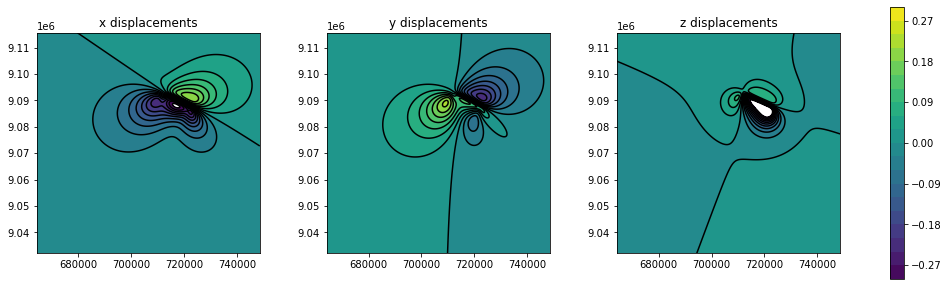

In [8]:
# and plot the output

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,5))  # set up three subplots (size in x and y)
fig.subplots_adjust(wspace=0.3)                            # space them out a little

axlist = [ax1,ax2,ax3]   # handles for your subplots

levels = np.linspace(-0.3, 0.3, 21)   # the bounds of your color scale - adjust if necessary

cntrf = ax1.contourf(x, y, UX.T, levels = levels)
first = ax1.contour(x, y, UX.T, colors = 'k', levels = levels, linestyles = 'solid')
ax1.axis('image')
ax1.title.set_text('x displacements')

cntrf = ax2.contourf(x, y, UY.T, levels = levels)
second = ax2.contour(x, y, UY.T, colors = 'k', levels = levels, linestyles = 'solid')
ax2.axis('image')
ax2.title.set_text('y displacements')

cntrf = ax3.contourf(x, y, UZ.T, levels = levels)
third = ax3.contour(x, y, UZ.T, colors = 'k', levels = levels, linestyles = 'solid')
ax3.axis('image')
ax3.title.set_text('z displacements')

fig.colorbar(cntrf, ax=axlist)

plt.show()

In [9]:
# now let's make some files

# check for hemisphere
if utml>='N':
#    print('Northern hemisphere')
    south=False
else:
#    print('Southern hemisphere')
    south=True
    
# to do gdal things, we need to know the spatial reference (epsg) code
epsg_code = 32600
epsg_code += int(utmz)
if south is True:
    epsg_code += 100
    

    
# some gdal things:
# set up the output destination (dst)

driver = gdal.GetDriverByName('GTiff')
dst_ds = driver.Create(out_tif_utm, xsize=nx, ysize=ny, bands=3, eType=gdal.GDT_Float32)
dst_ds.SetGeoTransform([minX, pix_size, 0, minY, 0, pix_size])

# set up our spatial reference system (srs)
srs = osr.SpatialReference()
srs.ImportFromEPSG(epsg_code)

# and write that thing out
dst_ds.SetProjection(srs.ExportToWkt())
dst_ds.GetRasterBand(1).WriteArray(UX.T)
dst_ds.GetRasterBand(2).WriteArray(UY.T)
dst_ds.GetRasterBand(3).WriteArray(UZ.T)

# finish by closing the dataset properly
dst_ds = None

# and now project into lat-long coordinates
# (for some reason, the functional form of this doesn't work properly)
!gdalwarp -overwrite -t_srs EPSG:4326 -tr $dE $dN -te $refLon $minLat $maxLon $refLat $out_tif_utm $out_tif_ll

# convert our reprojected tif to an ISCE format file    
!gdal_translate -of ISCE -ot Float32 $out_tif_ll $out_isce_ll

# and make a vrt file to go with it
out_isce_ll_vrt=out_isce_ll+'.vrt'
!gdal_translate -of VRT $out_isce_ll $out_isce_ll_vrt


Creating output file that is 2774P x 2704L.
Processing model_3components_utm.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 2774, 2704
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 2774, 2704


In [10]:
!gdal_translate -of ISCE -ot Float32 $out_tif_ll $out_isce_ll

Input file size is 2774, 2704
0...10...20...30...40...50...60...70...80...90...100 - done.


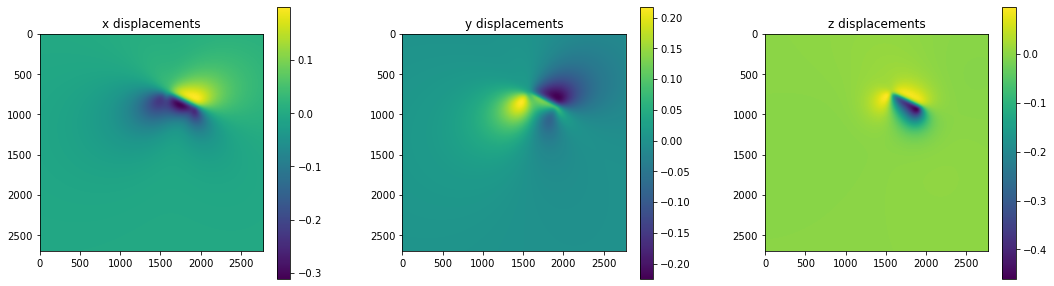

In [22]:
# now we need to load in our geocoded displacements and project them into LOS

llfile=gdal.Open(out_tif_ll,gdal.GA_ReadOnly)   # open with gdal

rb = llfile.GetRasterBand(1)                   # pick a band to plot
UX_ll = rb.ReadAsArray()                       # read it in as a number array
rb = llfile.GetRasterBand(2)                   # pick a band to plot
UY_ll = rb.ReadAsArray()                       # read it in as a number array
rb = llfile.GetRasterBand(3)                   # pick a band to plot
UZ_ll = rb.ReadAsArray()                       # read it in as a number array

# and plot them to make sure

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,5))  # set up three subplots (size in x and y)
fig.subplots_adjust(wspace=0.3)                            # space them out a little

axlist = [ax1,ax2,ax3]   # handles for your subplots

levels = np.linspace(-0.3, 0.3, 21)   # the bounds of your color scale - adjust if necessary

im1 = ax1.imshow(UX_ll,origin='upper')             # plot X displacements with origin at upper left (isce default)
fig.colorbar(im1, ax=ax1)                               # plot a color bar!
ax1.title.set_text('x displacements')

im2 = ax2.imshow(UY_ll,origin='upper')             # plot Y displacements with origin at upper left (isce default)
fig.colorbar(im2, ax=ax2)                               # plot a color bar!
ax2.title.set_text('y displacements')

im3 = ax3.imshow(UZ_ll,origin='upper')             # plot Z displacements with origin at upper left (isce default)
fig.colorbar(im3, ax=ax3)                               # plot a color bar!
ax3.title.set_text('z displacements')

plt.show()

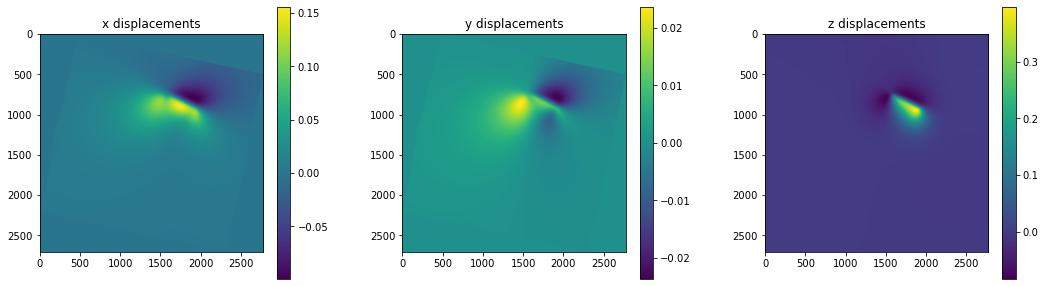

In [23]:
# let's make a fake interferogram!

LOSX = np.sin(np.radians(pnt))*np.sin(np.radians(inc))*sig_con        # x component of unit pointing vector
LOSY = (-1)*np.cos(np.radians(pnt))*np.sin(np.radians(inc))*sig_con   # y component
LOSZ = (-1)*np.cos(np.radians(inc))*sig_con                           # z component

ULOS = (LOSX*UX_ll + LOSY*UY_ll + LOSZ*UZ_ll)*4*np.pi/wavel 



# and plot them to make sure

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,5))  # set up three subplots (size in x and y)
fig.subplots_adjust(wspace=0.3)                            # space them out a little

axlist = [ax1,ax2,ax3]   # handles for your subplots

levels = np.linspace(-0.3, 0.3, 21)   # the bounds of your color scale - adjust if necessary

im1 = ax1.imshow(LOSX*UX_ll,origin='upper')             # plot X displacements with origin at upper left (isce default)
fig.colorbar(im1, ax=ax1)                               # plot a color bar!
ax1.title.set_text('x displacements')

im2 = ax2.imshow(LOSY*UY_ll,origin='upper')             # plot Y displacements with origin at upper left (isce default)
fig.colorbar(im2, ax=ax2)                               # plot a color bar!
ax2.title.set_text('y displacements')

im3 = ax3.imshow(LOSZ*UZ_ll,origin='upper')             # plot Z displacements with origin at upper left (isce default)
fig.colorbar(im3, ax=ax3)                               # plot a color bar!
ax3.title.set_text('z displacements')

plt.show()

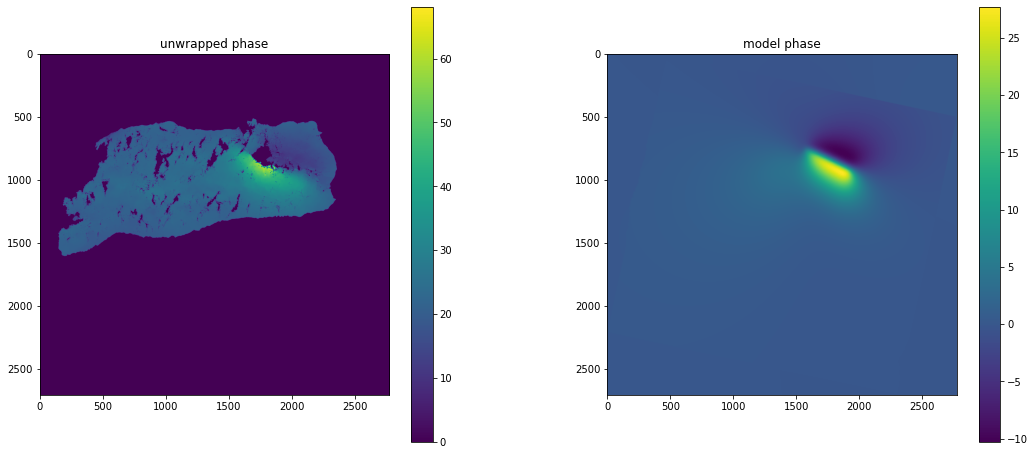

In [24]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,8))  # set up three subplots (size in x and y)
fig.subplots_adjust(wspace=0.3)                            # space them out a little

axlist = [ax1,ax2]   # handles for your subplots

levels = np.linspace(-0.3, 0.3, 21)   # the bounds of your color scale - adjust if necessary

im1 = ax1.imshow(phs,origin='upper')             # plot X displacements with origin at upper left (isce default)
fig.colorbar(im1, ax=ax1)                               # plot a color bar!
ax1.title.set_text('unwrapped phase')

im2 = ax2.imshow(ULOS,origin='upper')             # plot Y displacements with origin at upper left (isce default)
fig.colorbar(im2, ax=ax2)                               # plot a color bar!
ax2.title.set_text('model phase')

plt.show()

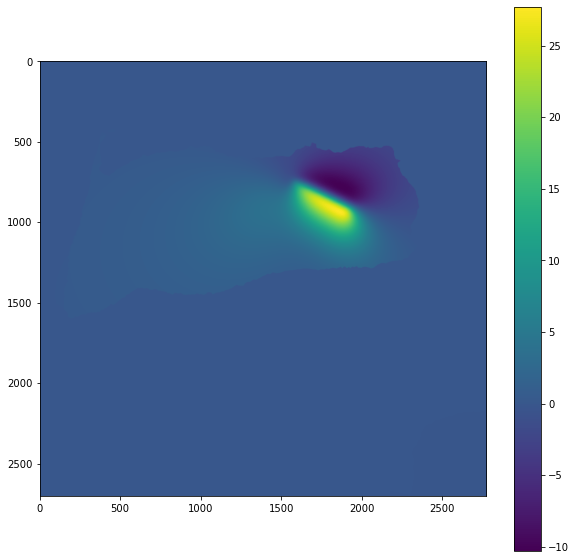

In [25]:
# let's mask the model
model= np.multiply(ULOS, wmask)  # masked with zeros
#mod_msk[wmask==0]=np.nan # masked with nan


# optionally plot your inputs
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(model,origin='upper')             # plot incidence with origin at upper left (isce default)
fig.colorbar(im)                               # plot a color bar!
plt.show()

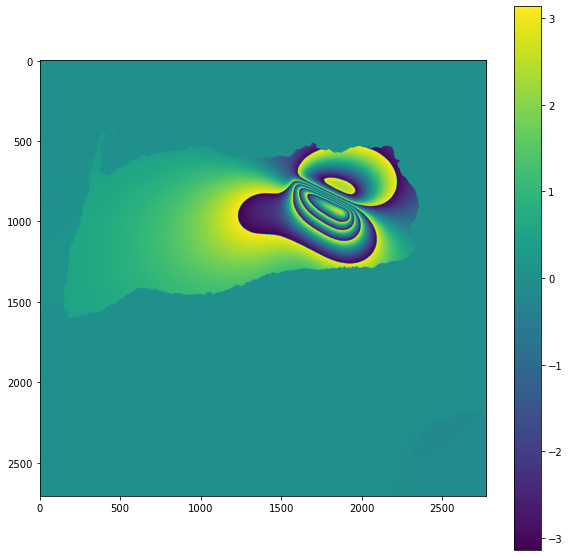

In [26]:
# let's wrap the model to compare and see if we like it 
wrap_mod= np.multiply(model, 1)

while np.nanmax(wrap_mod)>np.pi:
    # print("nanmax = {0:f}".format(np.nanmax(ULOS)))
    wrap_mod[wrap_mod>np.pi]-=2*np.pi

# and then do the same thing for all values below -pi
    
while np.nanmin(wrap_mod)<-np.pi:
    #print("nanmin = {0:f}".format(np.nanmin(ULOS)))
    wrap_mod[wrap_mod<-np.pi]+=2*np.pi

#
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(wrap_mod,origin='upper')             # plot the masked interferogram file
fig.colorbar(im)                               # plot a color bar!
plt.show()

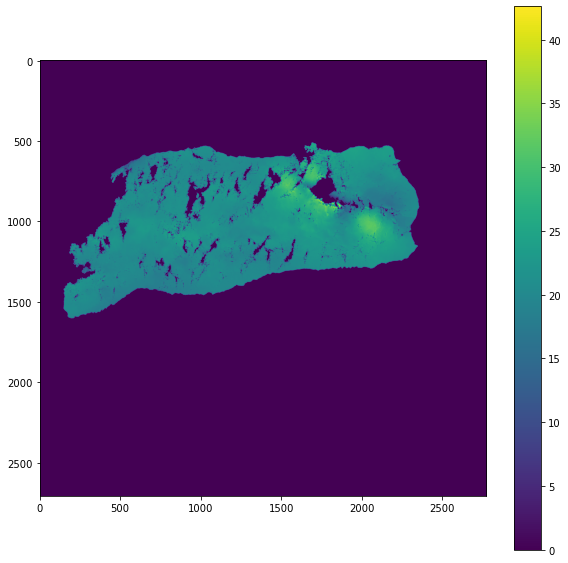

In [27]:
# mask with the connecting components 
residual_cc =np.multiply(phs-model, ccmask)

# mask with original water mask - be careful for errors in the model 
residual_wm= phs-model 

fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(residual_cc,origin='upper')             # plot the masked interferogram file
fig.colorbar(im)                               # plot a color bar!
plt.show()

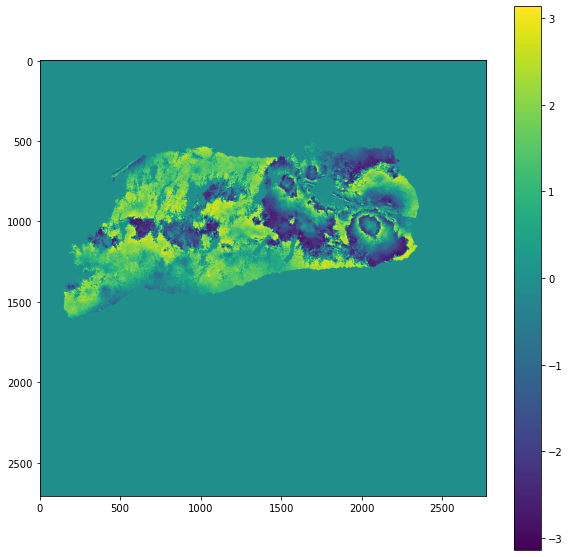

In [28]:
# wrap the residual 
w_residual= residual_cc*1

while np.nanmax(w_residual)>np.pi:
    # print("nanmax = {0:f}".format(np.nanmax(ULOS)))
    w_residual[w_residual>np.pi]-=2*np.pi

# and then do the same thing for all values below -pi
    
while np.nanmin(w_residual)<-np.pi:
    #print("nanmin = {0:f}".format(np.nanmin(ULOS)))
    w_residual[w_residual<-np.pi]+=2*np.pi

#
fig, ax = plt.subplots(figsize=(10,10))        # new figure called "ax1"
im = ax.imshow(w_residual,origin='upper')             # plot the masked interferogram file
fig.colorbar(im)                               # plot a color bar!
plt.show()

# Now we need to start saving things in ISCE
  (i) model (ii) residual

In [29]:
# save the MODEL with the water mask 
# some gdal things:
# set up and write out an ISCE format file for the model file
# added the out_isce_r
driver = gdal.GetDriverByName('ISCE')
dst_ds = driver.Create(out_isce, xsize=nE, ysize=nN, bands=1, eType=gdal.GDT_Float32)
dst_ds.SetGeoTransform([refLon, dE, 0, refLat, 0, dN])

# set up our spatial reference system (srs)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

# and write that thing out
dst_ds.SetProjection(srs.ExportToWkt())
dst_ds.GetRasterBand(1).WriteArray(model)

# finish by closing the dataset properly
dst_ds = None

# and now a vrt file
driver = gdal.GetDriverByName('VRT')
dst_ds = driver.Create(out_isce+'.vrt', xsize=nE, ysize=nN, bands=1, eType=gdal.GDT_Float32)
dst_ds.SetGeoTransform([refLon, dE, 0, refLat, 0, dN])


# finish by closing the dataset properly
dst_ds = None

In [30]:
# set up our spatial reference system (srs)
#srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

# and write that thing out
#dst_ds.SetProjection(srs.ExportToWkt())
#dst_ds.GetRasterBand(1).WriteArray(ULOS)

# finish by closing the dataset properly
#dst_ds = None

# now for the ISCEness
obj = isceobj.createImage()
obj.setFilename(out_isce)

obj.setWidth(nE) #Width is required -this would be the xsize= in los.file.RasterXsize

obj.setDataType('FLOAT')
obj.setInterleavedScheme('BIP') #BIL / BIP / BSQ
obj.setBands(1) # we only have band
obj.setAccessMode('read') #read / Write
obj.setCaster('read','FLOAT') #Mode needed in caster definition
obj.createImage() #Now object behaves like float image


###Use obj here for processing
# other words lets close the image!
obj.finalizeImage() #Close image after use
obj.renderHdr() #Create ISCE XML file if needed

GDAL open (R): model.geo.vrt
GDAL close: model.geo.vrt
API open (R): model.geo
API close:  model.geo


In [31]:
# SAVE THE RESIDUAL
# some gdal things:
# set up and write out an ISCE format file for the model file
# added the out_isce_r
driver = gdal.GetDriverByName('ISCE')
dst_ds = driver.Create(out_isce_residual, xsize=nE, ysize=nN, bands=1, eType=gdal.GDT_Float32)
dst_ds.SetGeoTransform([refLon, dE, 0, refLat, 0, dN])

# set up our spatial reference system (srs)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

# and write that thing out
dst_ds.SetProjection(srs.ExportToWkt())
dst_ds.GetRasterBand(1).WriteArray(residual_cc)

# finish by closing the dataset properly
dst_ds = None

# and now a vrt file
driver = gdal.GetDriverByName('VRT')
dst_ds = driver.Create(out_isce_residual+'.vrt', xsize=nE, ysize=nN, bands=1, eType=gdal.GDT_Float32)
dst_ds.SetGeoTransform([refLon, dE, 0, refLat, 0, dN])


# finish by closing the dataset properly
dst_ds = None

In [32]:
# set up our spatial reference system (srs)
#srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)

# and write that thing out
#dst_ds.SetProjection(srs.ExportToWkt())
#dst_ds.GetRasterBand(1).WriteArray(ULOS)

# finish by closing the dataset properly
#dst_ds = None

# now for the ISCEness
obj = isceobj.createImage()
obj.setFilename(out_isce_residual)

obj.setWidth(nE) #Width is required -this would be the xsize= in los.file.RasterXsize

obj.setDataType('FLOAT')
obj.setInterleavedScheme('BIP') #BIL / BIP / BSQ
obj.setBands(1) # we only have band
obj.setAccessMode('read') #read / Write
obj.setCaster('read','FLOAT') #Mode needed in caster definition
obj.createImage() #Now object behaves like float image


###Use obj here for processing
# other words lets close the image!
obj.finalizeImage() #Close image after use
obj.renderHdr() #Create ISCE XML file if needed

GDAL open (R): residual.geo.vrt
GDAL close: residual.geo.vrt
API open (R): residual.geo
API close:  residual.geo


In [38]:
# SAVE RESIDUAL AS GEOTIFF 
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create('residual.tif', nE, nN, 1, gdal.GDT_Float32)
outdata.SetGeoTransform(ifgfile.GetGeoTransform()) ##sets same geotransform as input
outdata.SetProjection(ifgfile.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(residual_cc)
outdata.GetRasterBand(1).SetNoDataValue(0)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!

## Changelog

    22-aug-2021  gjf  Calculate synthetic interferograms on a Cartesian grid
    11-nov-2021  gjf  Calculate UTM coordinates, output raster grid, project to lat-long
    15-nov-2021  gjf  Added git instructions
    24-jun-2022  gjf  Now does the full LOS projection in same geometry as interferogram
    20-jan-2023  kmr  Add a residual and outputs to save the model and residual 

    github.com/geniusinaction